___

# GridSearch: PyGSP for Mouse Phenotype prediction

In [175]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,accuracy_score,f1_score,matthews_corrcoef
from pygsp import graphs, filters, plotting, learning
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import norm
from IPython.core.debugger import set_trace

import networkx as nx
import itertools
from pycm import *
import pandas as pd
import numpy as np
import scipy
import os
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

## Import Data

<div class="alert alert-block alert-info">
* genotype_df: contains the genotype of each strain for each allele
* phenotype_df : contains the phenotypes of each strain, lots of Nan

NB: on this branch of the project, we don't use the expression of the genes, and try instead to predict straight the phenotype from the genotype: therefore, we don't import any file from expression data.
</div>

In [176]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')

# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'

print("There is NaN values: %s" % genotype_df.isna().any().any())

phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')

# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

print("Number of Nan values: %s" % nan_count)
print("Percentage of nan in the phenotype file: {:0.2f}%".format(nan_count / entries_count * 100))

There is NaN values: False
Number of Nan values: 291981
Percentage of nan in the phenotype file: 61.66%


### Phenotype_id_aligner

<div class="alert alert-block alert-info">
The phenotype id aligner gives us insight in the characteristics of the different genes.
</div>

In [45]:
# Phenotype id aligne is an in-depth description of each phenotype
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')
phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)
quant_pheno_best = phenotype_id_aligner[(phenotype_id_aligner.Strains > 70) & (phenotype_id_aligner.quantitative_trait == 'No')]
quant_pheno_best = quant_pheno_best.sort_values(by='Strains', ascending=False)

In [46]:
phenotype_id_aligner[phenotype_id_aligner.PhenoID == 'X62']

,PhenoID,PhenoID.1,RecordID,Phenotype,Shown_pheno,Category,Category_ID,color,Phenotype_post,Phenotype_pre,Authors,Senior.Author,Abbreviation,quantitative_trait,Tissues,Diet,Strains
2627,X62,62,11280,"Skin, pigmentation: Hair coat color, ordinal s...","Hair coat color, ordinal scale version 2 where...",Morphology,2628.0,9.0,"Skin, pigmentation: Hair coat color, ordinal s...","Skin, pigmentation: Hair coat color, ordinal s...","Lu Lu, Jing Gu, Robert Williams",Williams,NaN,No,NaN,NaN,94


# Similarity graphs

<div class="alert alert-block alert-info">
We construct a weighted similarity graph and keep only the edges whose exponential value are above a given threshold epsilon : we can construct our graph based on 2 types of information: either genetic or expressive (protein expression). 
</div>

In [199]:
def epsilon_similarity_graph(X: np.ndarray, metric='euclidean', sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    if np.isnan(X).any():
        Dists = squareform(np.array([pdist(X[s][:, ~np.isnan(X[s]).any(axis=0)], metric,p=1) for s in map(list, itertools.combinations(range(X.shape[0]), 2))]).ravel())
        Dists[Dists == 0] = 1E8
        Dists = np.nan_to_num(Dists,nan = 1E8)
    else:
        Dists = squareform(pdist(X,metric = metric,p = 1))
    
    Dists = np.exp(-Dists**2/(2 * sigma**2))
    Dists[Dists <= epsilon] = 0
    np.fill_diagonal(Dists,0)
    return Dists

In [48]:
def plot_distrib(adjacency):
    """ Plot the density of kerneled distances
    
    Args: 
        adjacency (np.array): adjacency matrix
        
    """
    non_zero = adjacency[np.nonzero(adjacency)]
    print("{:0.2f} % of the original data is kept".format(non_zero.size / adjacency.size * 100))
    plt.plot(np.sort(non_zero)[::-1])

## Genotype similarity graph

51.38 % of the original data is kept


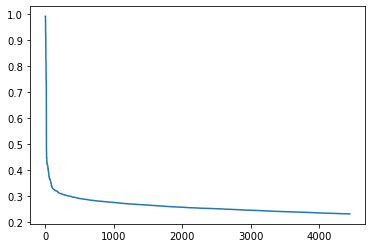

In [193]:
k = epsilon_similarity_graph(genotype_df.values,sigma = 70,epsilon = 0.23,metric = 'cosine')
plot_distrib(k)

## Expression Similarity Graph

<div class="alert alert-block alert-info">
In order to deal with missing values, we compute the distance according to the given criteria (minkowsky,l2 etc) only on the common features. If 2 samples don't share any feature, then they are considered disconnected.
</div>

In [181]:
with open('data/pickle/concat_expression.pkl','rb') as f:
    expr_df = pickle.load(f)
expr_df['nancount'] = expr_df.isnull().sum(axis = 1)
if False:
    #we only take the genes whose values of nan is the minimum (10)
    expr_df = expr_df[expr_df.nancount == expr_df.nancount.min()].drop(columns = ['nancount'])
else:
    #we take the N first genes with the less nan values
    expr_df = expr_df.sort_values(by = 'nancount').head(100000).drop(columns = ['nancount'])
    
#remove the mouses which don't have information in this top
expr_df = expr_df.T[~expr_df.isna().all()]

50.76 % of the original data is kept


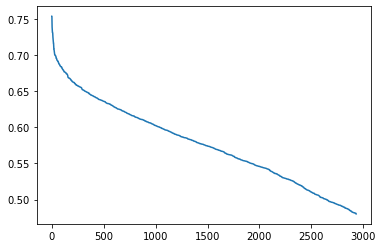

In [201]:
m = epsilon_similarity_graph(expr_df.values,sigma = 48,epsilon = 0.48,metric = 'euclidean')
E = expr_df.values
plot_distrib(m)

88.12 % of the original data is kept


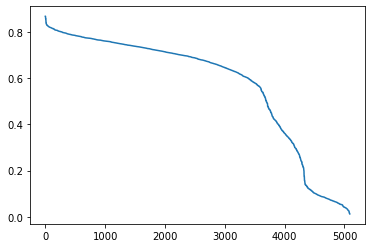

In [204]:
m = epsilon_similarity_graph(expr_df.values,sigma = 9000,epsilon = 0,metric = 'minkowski')
E = expr_df.values
plot_distrib(m)

# Exploitation

TODO:
* adapt the grid_search_graphs function s.t. it can compute the adjacency matrix with the gene expression data.

<div class="alert alert-block alert-info">
At that point, all we need is a pygsp graph describing the different strains: the way it is linked is therefore critical for the success of the algorithm.
</div>

In [58]:
def get_min_max(params_scores):
    """params_scores: list of list with each row having the following information
    f1,acc,met,sig,eps,tau"""
    #we sort according to the accuracy
    sorto = lambda x: x[0]
    mino = min(params_scores,key = sorto)[0]
    maxo = max(params_scores,key = sorto)[0]
    return mino,maxo

In [59]:
def grid_search_graphs(bio_df,CV_meth,metrics,sigmas,epsilons,taus,gene):
    """
    bio_df = genotype_df or expr_df
    CV_meth: a method performing cross validation (on discrete or continuous variable)
    metrics: list of metrics usable in a pdist matrix
    sigmas,epsilons: parameter for the adjacency matrix we do the grid search on
    """
    params_scores = []
    tot_comb = len(metrics) * len(sigmas) * len(epsilons) * len(taus)
    for i,met in enumerate(metrics):
        for j,sig in enumerate(sigmas):
            for k,eps in enumerate(epsilons):
                for l,tau in enumerate(taus):
                    ind = l + len(taus) * (k + len(epsilons) * (j + len(sigmas) * (i)))
                    if (ind % 10 == 0):
                        print(" %i / %i combinations" % (ind,tot_comb))
                    try:
                        weighted_adjacency = epsilon_similarity_graph(bio_df.values, metric=met, sigma=sig, epsilon=eps)
                        pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
                        f1,acc = CV_meth(pygsp_weighted_graph,phenotype_df.loc[gene],bio_df,tau)
                        params_scores.append([f1,acc,met,sig,eps,tau])
                    except nx.NetworkXError:
                        print('non connected graph with %.2f sigma and %.2f epsilon' % (sig,eps))
                        continue
    mino,maxo = get_min_max(params_scores)
    print('#' * 32)
    print('Biggest result for gene %s : %.2f' % (gene,maxo))
    print('Smallest result for gene %s : %.2f' % (gene,mino))
    print('#' * 32)
    return params_scores
    

### Labels (hair coat color)

In [64]:
def CV_discrete(pygsp_weighted_graph,gene_serie,bio_df,tau,NUM_REPET = 50,plot = False):
    y_true = gene_serie[bio_df.index]
    nan_present = y_true.isnull().any()
    
    if nan_present:
        nan_indxes = np.where(np.isnan(y_true))[0]
        y_true = y_true.astype('category').cat.codes
        y_true = y_true + 1
        assert(y_true[nan_indxes][0] == 0)
    else:
        y_true = y_true.astype('category').cat.codes
        y_true = y_true + 1
    
    met,acc = 0,0
    for i in range(NUM_REPET):
        rs = np.random.RandomState()
        train_mask = rs.uniform(0,1,pygsp_weighted_graph.N) > 0.2
        #we make sure that the nan always end up in the train
        if nan_present:
            train_mask[nan_indxes] = True
        labels_true = y_true[~train_mask]
        y_sparse = y_true.copy()
        y_sparse[~train_mask] = np.nan

        recovery = learning.classification_tikhonov(pygsp_weighted_graph,y_sparse,train_mask,tau=tau)
        
        #we get rid of the 0 value: we don't accept no label
        #if nan_present:
        #    recovery[:,0] = -1
        prediction = np.argmax(recovery, axis=1)
        
        labels_pred = prediction[~train_mask]
        met += matthews_corrcoef(labels_true,labels_pred)
        acc += accuracy_score(labels_true,labels_pred)
    #set_trace()
    met_final = met/NUM_REPET
    acc_final = acc/NUM_REPET
    if plot:
        #useful to chose metrics
        cm = ConfusionMatrix(actual_vector=labels_true.values, predict_vector=labels_pred)
        print('MCC:%.2f \nAccuracy:%.2f'% (met_final,acc_final))
        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
        limits = [min(y_true.unique().min(),0),y_true.unique().max()+ 1]
        #ground truth
        pygsp_weighted_graph.plot_signal(y_true, ax=ax[0], title='Ground truth',limits = limits)
        #measurements
        pygsp_weighted_graph.plot_signal(y_sparse, ax=ax[1], title='Measurements',limits = limits)
        #recover
        prediction = [limits[1] + 1 if i == j and not k else i for i,j,k in zip(prediction,y_true,train_mask)]
        pygsp_weighted_graph.plot_signal(prediction, ax=ax[2], title='Recovered class',limits = limits)
    return met_final,acc_final

In [61]:
def CV_continuous(pygsp_weighted_graph,gene_serie,bio_df,tau,NUM_REPET = 50,metric_meth = r2_score,plot = False):
    ycont_true = gene_serie[bio_df.index]
    ycont_true.fillna(ycont_true.mean(),inplace = True)
    #mae or mse
    mxe = 0
    for i in range(NUM_REPET):
        mask = np.random.RandomState().uniform(0,1,pygsp_weighted_graph.N) > 0.2
        vals_true = ycont_true[~mask]
        ycont_sparse = ycont_true.copy()
        ycont_sparse[~mask] = np.nan

        recovery = learning.regression_tikhonov(pygsp_weighted_graph,ycont_sparse,mask,tau=tau)
        if any(np.isnan(recovery)):
            return np.nan
        vals_pred = recovery[~mask]
        mxe += metric_meth(vals_true,vals_pred)

    mxe_avg = mxe / NUM_REPET
    if plot:
        print(str(metric_meth),mxe_avg)
        fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
        limits = [ycont_true.min(),ycont_true.max()]

        #ground truth
        pygsp_weighted_graph.plot(ycont_true, ax=ax[0],limits = limits, title='Ground truth')
        #measurements
        pygsp_weighted_graph.plot_signal(ycont_sparse, ax=ax[1],limits = limits, title='Measurements')
        #recover
        pygsp_weighted_graph.plot_signal(recovery, ax=ax[2],limits = limits, title='Recovered class')
    return mxe_avg,0

# Instanciations

In [62]:
top_variables = phenotype_df.join(phenotype_id_aligner.set_index('PhenoID')[['quantitative_trait']],how = 'inner').copy()
top_variables['nan_count'] = top_variables.isnull().sum(axis = 1)

top_continuous = top_variables[top_variables.quantitative_trait == 'Yes']\
                                            .sort_values('nan_count')\
                                            .head(30)\
                                            .drop(columns = ['nan_count','quantitative_trait'])\
                                            .copy()

top_discrete = top_variables[top_variables.quantitative_trait == 'No']\
                                          .sort_values('nan_count')\
                                          .head(30)\
                                          .drop(columns = ['nan_count','quantitative_trait'])\
                                          .copy()

top_discrete = top_discrete[top_discrete.T.nunique() <10]
top_discrete.drop('X57',inplace = True)
"""top_discrete = top_discrete.astype('category')
catcols = top_discrete.select_dtypes(['category']).columns
top_discrete[catcols] = top_discrete[catcols].apply(lambda x: x.cat.codes)"""

top_discrete = top_discrete.T
top_continuous = top_continuous.T

print('The best continuous variables are : {} \n'.format(' '.join(top_continuous.columns.values)))
print('The best discrete variables are : {}'.format(' '.join(top_discrete.columns.values)))


top_disc = top_discrete.columns.values
top_cont = top_continuous.columns.values

The best continuous variables are : X3820 X2397 X1002 X328 X218 X416 X699 X1302 X2147 X2164 X885 X1206 X2334 X2230 X1646 X1977 X424 X2041 X4482 X332 X228 X3903 X4556 X4256 X4849 X5029 X2490 X457 X2645 X2689 

The best discrete variables are : X546 X152 X111 X1012 X4473 X64 X62 X63 X76 X61


## Visual instantiation

We do an example of genetic based network with fixed parameters and see how the algorithm performs visually.

MCC:0.27 
Accuracy:0.43


(0.27488124980168677, 0.43478260869565216)

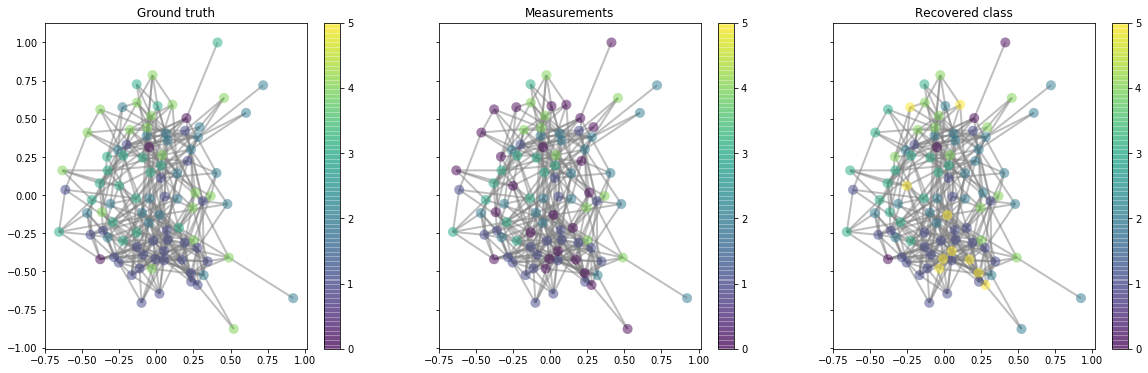

In [65]:
weighted_adjacency = epsilon_similarity_graph(genotype_df.values, metric='cosine', sigma=70, epsilon=0.28)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized') 
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,top_discrete['X62'],genotype_df,0,1,True)


## Grid Searches

### Genetic based

In [34]:
#small parameters for tests
METRICS = ['cosine']
SIGMAS = [60,70]
EPSILONS = [0.28]
TAUS = [0.1]

In [66]:
#real parameters for genetic
METRICS = ['cosine','jaccard','hamming','euclidian']
SIGMAS = np.arange(60,76,14)
EPSILONS = np.arange(0.2,0.4,0.04)
TAUS = np.logspace(0,np.log10(10),3)

<div class="alert alert-block alert-info">
Discrete features, genetic based
</div>

In [67]:
dic_disc_gen = {}
for gene in top_disc:
    result = np.nan
    result = grid_search_graphs(genotype_df,CV_discrete,METRICS,SIGMAS,EPSILONS,TAUS,gene)
    dic_disc_gen[gene] = result
    with open('results/dic_disc_gen.pickle','wb') as f:
        pickle.dump(dic_disc_gen,f)

 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X546 : 0.25
Smallest result for gene X546 : -0.03
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X152 : 0.33
Smallest result for gene X152 : 0.00
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X111 : 0.54
Smallest result for gene X111 : 0.00
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X1012 : 0.20
Smallest result for gene X1012 : -0.07
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X4473 : 0.20
Smallest result for gene X4473 : -0.07
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X64 : 0.33
Smallest result for gene X64 : 0.00
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X62 : 0.33
Smallest result for gene X62 : 0.00
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X63 : 0.33
Smallest result for gene X63 : 0.00
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

################################
Biggest result for gene X76 : 0.13
Smallest result for gene X76 : -0.01
################################
 0 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterat

 10 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 20 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a

 30 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 40 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterat

 50 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 60 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterat

 70 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 80 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 90 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 100 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7

 110 / 120 combinations


/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``
  
/Users/ymentha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py

################################
Biggest result for gene X61 : 0.14
Smallest result for gene X61 : -0.06
################################


In [69]:
get_top_genes(5,dic_disc_gen)

[('X111',
  [0.5412550880636663,
   0.7717125378547505,
   'cosine',
   74,
   0.32000000000000006,
   1.0]),
 ('X63',
  [0.3324421814028884,
   0.49436699369788606,
   'euclidian',
   74,
   0.32000000000000006,
   1.0]),
 ('X62',
  [0.3306937273973073,
   0.3453923576572992,
   'hamming',
   60,
   0.24000000000000002,
   1.0]),
 ('X152',
  [0.32685919386941703, 0.5890349089081153, 'euclidian', 60, 0.2, 1.0]),
 ('X64',
  [0.32562895081980897,
   0.4971272431753049,
   'hamming',
   74,
   0.32000000000000006,
   1.0])]

<div class="alert alert-block alert-info">
Continuous features, genetic based
</div>

In [51]:
dic_cont_gen = {}
for gene in top_cont:
    print('#'*20 + "%i/%i genes" % (i,len(top_disc))+'#'*20)
    results_cont = grid_search_graphs(genotype_df,CV_continuous,METRICS,SIGMAS,EPSILONS,TAUS,gene)
    ind_max = np.nanargmax([i[0] for i in results_cont])
    r2 = results_cont[ind_max]
    dic_cont_gen[gene] = results_cont
    with open('results/dic_cont_gen.pickle','wb') as f:
        pickle.dump(dic_cont_gen,f)

 0 / 2 combinations
################################
Biggest result for gene X3820 : -0.48
Smallest result for gene X3820 : -3.34
################################
 0 / 2 combinations
################################
Biggest result for gene X2397 : -2.23
Smallest result for gene X2397 : -25.82
################################
 0 / 2 combinations
################################
Biggest result for gene X1002 : -28.57
Smallest result for gene X1002 : -295.05
################################
 0 / 2 combinations
################################
Biggest result for gene X328 : -23.06
Smallest result for gene X328 : -331.53
################################
 0 / 2 combinations
################################
Biggest result for gene X218 : -26.27
Smallest result for gene X218 : -370.29
################################
 0 / 2 combinations
################################
Biggest result for gene X416 : -32.63
Smallest result for gene X416 : -394.65
################################
 0 / 2 combinat

## Expression based

In [168]:
#small parameters for tests
METRICS_E = ['euclidean']
SIGMAS_E = [60]
EPSILONS_E = [0.28]
TAUS_E = [0.1]

In [84]:
#real params for expression
METRICS_E = ['euclidean','minkowski']
SIGMAS_E = np.arange(60,76,2)
EPSILONS_E = np.arange(0.2,0.4,0.2)
TAUS_E = np.logspace(0,np.log10(10),2)

<div class="alert alert-block alert-info">
Discrete features, expression based
</div>

In [ ]:
dic_disc_exp = {}
for i,gene in enumerate(top_disc):
    print('#'*20 + "%i/%i genes" % (i,len(top_disc))+'#'*20)
    result = np.nan
    result = grid_search_graphs(expr_df,CV_discrete,METRICS_E,SIGMAS_E,EPSILONS_E,TAUS_E,gene)
    dic_disc_exp[gene] = result
    with open('results/dic_disc_exp.pickle','wb') as f:
        pickle.dump(dic_disc_exp,f)

####################0/10 genes####################
 0 / 32 combinations
 10 / 32 combinations


<div class="alert alert-block alert-info">
Continuous features, expression based
</div>

In [13]:
dic_cont_exp = {}
for gene in top_cont:
    results_cont = grid_search_graphs(genotype_df,CV_cont_phen,METRICS,SIGMAS,EPSILONS,TAUS,gene)
    ind_max = np.nanargmax([i[0] for i in results_cont])
    r2 = results_cont[ind_max]
    dic_cont[gene] = results_cont
    with open('results/dic_cont_exp.pickle','wb') as f:
        pickle.dump(dic_cont,f)


 0 / 2 combinations
################################
Biggest result for gene X3820 : -0.56
Smallest result for gene X3820 : -3.51
################################
 0 / 2 combinations
################################
Biggest result for gene X2397 : -2.36
Smallest result for gene X2397 : -29.02
################################
 0 / 2 combinations
################################
Biggest result for gene X1002 : -24.32
Smallest result for gene X1002 : -330.92
################################
 0 / 2 combinations
################################
Biggest result for gene X328 : -21.80
Smallest result for gene X328 : -289.72
################################
 0 / 2 combinations
################################
Biggest result for gene X218 : -27.16
Smallest result for gene X218 : -332.92
################################
 0 / 2 combinations
################################
Biggest result for gene X416 : -31.50
Smallest result for gene X416 : -353.17
################################
 0 / 2 combinat

# PostAnalysis of the best genes

In [59]:
with open('results/dic_cont_bigrun.pickle','rb') as f:
    dic_cont = pickle.load(f)
with open('results/dic_disc_bigrun.pickle','rb') as f:
    dic_disc = pickle.load(f)

In [68]:
def get_top_genes(n,dico):
    """
    return the n first top genes with best score
    """
    maxo = lambda x: max(x,key = lambda x:x[0])
    maxvec = [(key,maxo(val)) for key,val in dico.items()]
    return sorted(maxvec,key = lambda x: x[1],reverse = True)[:n]

<div class="alert alert-block alert-info">
We now check which genes gave the best results with the grid search.
</div>

In [64]:
get_top_genes(15,dic_disc)

[('X57', [1.0, ('cosine', 60, 0.2, 1.0)]),
 ('X61',
  [0.7847612191924078, ('cosine', 75, 0.3200000000000001, 59948425.03189421)]),
 ('X1012',
  [0.7758423098999085,
   ('jaccard', 75, 0.3000000000000001, 2154.4346900318847)]),
 ('X546',
  [0.7524638995485006,
   ('jaccard', 75, 0.24000000000000005, 59948425.03189421)]),
 ('X76',
  [0.7096777387857952, ('hamming', 75, 0.2800000000000001, 10000000000.0)]),
 ('X152',
  [0.655744472642613,
   ('cosine', 75, 0.25000000000000006, 2154.4346900318847)]),
 ('X111',
  [0.6535484335299518, ('cosine', 75, 0.26000000000000006, 10000000000.0)]),
 ('X63', [0.5189940826997295, ('euclidian', 75, 0.34000000000000014, 1.0)]),
 ('X64', [0.4944742765759389, ('hamming', 75, 0.3300000000000001, 1.0)]),
 ('X62', [0.49153061426391625, ('jaccard', 75, 0.3300000000000001, 1.0)]),
 ('X343',
  [0.47768812281330786,
   ('cosine', 75, 0.26000000000000006, 2154.4346900318847)]),
 ('X646',
  [0.4643544190863952,
   ('cosine', 75, 0.23000000000000004, 166.810053720005

In [43]:
get_top_genes(5,dic_cont)

[('X3903',
  [0.05792128631767765,
   ('hamming', 75, 0.2800000000000001, 774263682.6811278)]),
 ('X4256', [0.05075089134353906, ('euclidian', 75, 0.2800000000000001, 1.0)]),
 ('X699',
  [0.04357581399441038,
   ('cosine', 75, 0.23000000000000004, 2154.4346900318847)]),
 ('X4849',
  [0.03459409735234803,
   ('cosine', 75, 0.2800000000000001, 359381.36638046254)]),
 ('X1977',
  [0.024576548473202068,
   ('hamming', 75, 0.24000000000000005, 359381.36638046254)])]

<div class="alert alert-block alert-info">
And reproduce the result.
</div>

MCC:0.00 
Accuracy:0.94


(0.0, 0.9375)

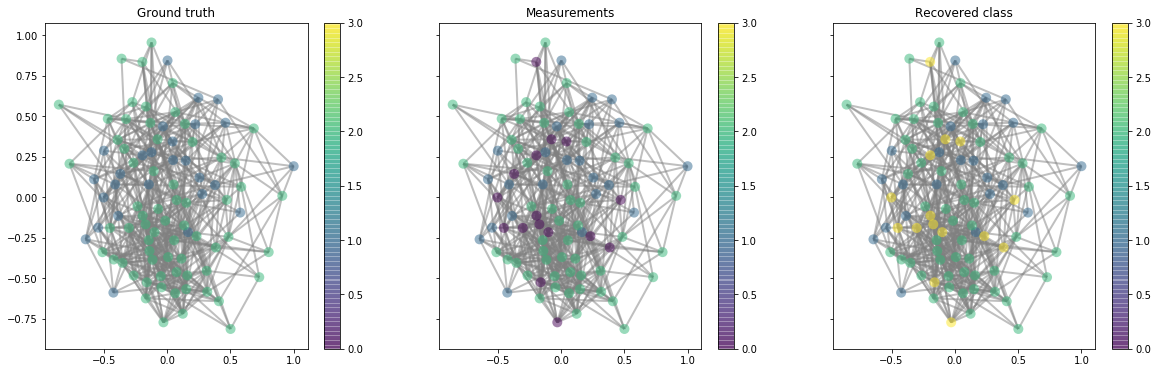

In [174]:
weighted_adjacency = epsilon_similarity_graph(genotype_df.values, metric='hamming', sigma=75, epsilon=0.32)
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')
pygsp_weighted_graph.set_coordinates()
CV_discrete(pygsp_weighted_graph,phenotype_df.loc['X546'],genotype_df,0,NUM_REPET=1,plot = True)

In [ ]:
#trash

In [125]:
cm.recommended_list

['ERR',
 'TPR Micro',
 'TPR Macro',
 'F1 Macro',
 'PPV Macro',
 'ACC',
 'Overall ACC',
 'MCC',
 'MCCI',
 'Overall MCC',
 'SOA6(Matthews)',
 'BCD',
 'Hamming Loss',
 'Zero-one Loss']